In [1]:
# Dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import calendar
import scipy.stats as st

In [2]:
#CLEAN THE AIRBNB DATA
AirBnB_df = pd.read_csv('Resources/AB_US_2020.csv')
AirBnB_df.head()

C:\Users\grace\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [3]:
#Add date column that states month-year to match city sales df headers
last_review = AirBnB_df.loc[:,'last_review']
AirBnB_df['last_review'] = AirBnB_df['last_review'].fillna('00/00/00')

new_dates_list = []
for date in last_review:
    if int(date[:2]) > 12:
        split_date = date.split('/')
        new_date = f'20{split_date[2]}-{split_date[1]}'
        new_dates_list.append(new_date)
        
    elif int(date[:2]) <= 12:
        split_date = date.split('/')
        new_date = f'20{split_date[2]}-{split_date[0]}'
        new_dates_list.append(new_date)

AirBnB_df['Month/Year'] = new_dates_list


In [4]:
#Change New York City to New York
AirBnB_df = AirBnB_df.replace("New York City","New York")
AirBnB_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,Month/Year
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville,2020-02
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville,2020-07
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville,2019-11
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville,2020-09
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville,2015-10


In [5]:
#Change NaN for review_per_month to 0
AirBnB_df['reviews_per_month'] = AirBnB_df['reviews_per_month'].fillna(0)


In [6]:
# SALES CITY DATA
#Pull in Sales City data
sales_city_df = pd.read_csv('Resources/House_Sales_City.csv')

In [7]:
#Group Sales City Data and check duplicate cities (will have counts > 1)
grouped_df = sales_city_df.groupby('RegionName').count()

In [8]:
#Pull rows where values = 1 to get non-duplicate cities
sales_city_list = grouped_df[grouped_df['RegionID']==1].index


In [9]:
#Unique cities in the AirBnB data
thelist = AirBnB_df['city'].unique()

In [10]:
#Pull sales city data from cities in AirBnB data
clean_city_df = sales_city_df[sales_city_df['RegionName'].isin(sales_city_list)]
clean_city_df = clean_city_df[clean_city_df['RegionName'].isin(thelist)]

In [11]:
#Merge both data sets
merged_data = AirBnB_df.merge(clean_city_df, right_on = 'RegionName', left_on = 'city')

In [12]:
print(merged_data.columns)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       ...
       '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
       '2019-12', '2020-01', '2020-02', '2020-03'],
      dtype='object', length=168)


In [13]:
# Group by 
room_type_df = merged_data.groupby(['city','room_type'])
mean_df = room_type_df.mean()['price']
mean_df

city           room_type      
Asheville      Entire home/apt    217.679929
               Hotel room         288.894737
               Private room        96.989011
               Shared room         66.285714
Boston         Entire home/apt    209.967623
               Hotel room         223.444444
               Private room        94.322242
               Shared room        129.875000
Chicago        Entire home/apt    176.388548
               Hotel room         518.479452
               Private room        87.431533
               Shared room         49.688889
Jersey City    Entire home/apt    171.609159
               Hotel room          97.225806
               Private room        73.588670
               Shared room         91.019608
Los Angeles    Entire home/apt    294.598539
               Hotel room         152.019108
               Private room        96.918077
               Shared room         52.363806
New Orleans    Entire home/apt    183.962107
               Hotel roo

In [14]:
merged_data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.651460,-82.627920,Private room,60,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.597790,-82.555400,Entire home/apt,470,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.606700,-82.555630,Entire home/apt,75,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.578640,-82.595780,Entire home/apt,90,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.614420,-82.541270,Private room,125,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124204,43805501,"Modern Boutique Apt in S. Lake Union, Gym +Pet...",218805459,Eric,Cascade,South Lake Union,47.624490,-122.335400,Entire home/apt,109,...,699000.0,690700.0,690800.0,684800.0,697300.0,692100.0,701700.0,701400.0,705600.0,NaN
124205,43807087,Beautiful & Bright Downtown Studio,130366604,Logan,Downtown,Belltown,47.615020,-122.342490,Entire home/apt,119,...,699000.0,690700.0,690800.0,684800.0,697300.0,692100.0,701700.0,701400.0,705600.0,NaN
124206,43807576,3 BDRM/1.75 bath Top Queen Anne home@quiet street,7435040,Chengying,Queen Anne,West Queen Anne,47.639570,-122.360840,Entire home/apt,299,...,699000.0,690700.0,690800.0,684800.0,697300.0,692100.0,701700.0,701400.0,705600.0,NaN
124207,43807578,Perfect & Bright Downtown Studio,130366604,Logan,Downtown,Belltown,47.615070,-122.340490,Entire home/apt,119,...,699000.0,690700.0,690800.0,684800.0,697300.0,692100.0,701700.0,701400.0,705600.0,NaN


In [15]:
mycols = list(merged_data.columns)
mycols

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'city',
 'Month/Year',
 'Unnamed: 0',
 'RegionID',
 'RegionName',
 'StateName',
 'SizeRank',
 '2008-03',
 '2008-04',
 '2008-05',
 '2008-06',
 '2008-07',
 '2008-08',
 '2008-09',
 '2008-10',
 '2008-11',
 '2008-12',
 '2009-01',
 '2009-02',
 '2009-03',
 '2009-04',
 '2009-05',
 '2009-06',
 '2009-07',
 '2009-08',
 '2009-09',
 '2009-10',
 '2009-11',
 '2009-12',
 '2010-01',
 '2010-02',
 '2010-03',
 '2010-04',
 '2010-05',
 '2010-06',
 '2010-07',
 '2010-08',
 '2010-09',
 '2010-10',
 '2010-11',
 '2010-12',
 '2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '2011-10',
 '2011-11',
 '2011-12',
 '2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',


In [16]:
new_df_cols = ['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'city',
 'Month/Year',
 'Unnamed: 0',
 'RegionID',
 'RegionName',
 'StateName',
 'SizeRank','2020-01',
 '2020-02',
 '2020-03']

new_df = merged_data[new_df_cols]
new_df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,city,Month/Year,Unnamed: 0,RegionID,RegionName,StateName,SizeRank,2020-01,2020-02,2020-03
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.651460,-82.627920,Private room,60,...,Asheville,2020-02,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.597790,-82.555400,Entire home/apt,470,...,Asheville,2020-07,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.606700,-82.555630,Entire home/apt,75,...,Asheville,2019-11,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.578640,-82.595780,Entire home/apt,90,...,Asheville,2020-09,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.614420,-82.541270,Private room,125,...,Asheville,2015-10,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124204,43805501,"Modern Boutique Apt in S. Lake Union, Gym +Pet...",218805459,Eric,Cascade,South Lake Union,47.624490,-122.335400,Entire home/apt,109,...,Seattle,2000-00,23,16037,Seattle,Washington,24,701400.0,705600.0,NaN
124205,43807087,Beautiful & Bright Downtown Studio,130366604,Logan,Downtown,Belltown,47.615020,-122.342490,Entire home/apt,119,...,Seattle,2000-00,23,16037,Seattle,Washington,24,701400.0,705600.0,NaN
124206,43807576,3 BDRM/1.75 bath Top Queen Anne home@quiet street,7435040,Chengying,Queen Anne,West Queen Anne,47.639570,-122.360840,Entire home/apt,299,...,Seattle,2000-00,23,16037,Seattle,Washington,24,701400.0,705600.0,NaN
124207,43807578,Perfect & Bright Downtown Studio,130366604,Logan,Downtown,Belltown,47.615070,-122.340490,Entire home/apt,119,...,Seattle,2000-00,23,16037,Seattle,Washington,24,701400.0,705600.0,NaN


In [17]:
new_mean_df = new_df.groupby(by='city').mean()
new_mean_df

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Unnamed: 0,RegionID,SizeRank,2020-01,2020-02,2020-03
city,,,,,,,,,,,,,,,,
Asheville,2.682800e+07,9.575666e+07,35.578745,-82.556585,196.639344,4.964802,78.101736,2.676162,5.620058,163.318226,390.0,50779.0,391.0,299800.0,309000.0,310900.0
Boston,2.695210e+07,1.059110e+08,42.337520,-71.082978,170.331836,35.754118,37.990716,1.134400,28.746032,184.506739,25.0,44269.0,26.0,644300.0,665400.0,692200.0
Chicago,2.813857e+07,9.850262e+07,41.899049,-87.664042,153.020009,8.113178,42.753791,1.436439,13.598718,174.272159,3.0,17426.0,4.0,281400.0,302900.0,309200.0
Jersey City,2.860093e+07,1.089726e+08,40.726941,-74.054797,137.039791,8.834003,28.149920,1.163320,13.967846,183.807878,83.0,25320.0,84.0,498200.0,517400.0,583600.0
Los Angeles,2.631011e+07,1.005559e+08,34.046130,-118.315923,222.682046,18.371322,35.318430,1.152120,11.467529,173.790430,1.0,12447.0,2.0,738200.0,760200.0,NaN
New Orleans,2.635798e+07,1.092524e+08,29.958402,-90.074819,174.975343,8.180087,51.405587,1.568009,11.500312,175.231898,48.0,19594.0,49.0,250700.0,248100.0,249000.0
New York,2.309535e+07,8.437272e+07,40.729633,-73.950747,149.557413,8.767703,22.560189,0.678508,5.964813,120.740733,0.0,6181.0,1.0,571700.0,568300.0,573600.0
Pacific Grove,2.356141e+07,1.107012e+08,36.621463,-121.920831,251.111732,15.351955,75.067039,1.776760,7.290503,179.692737,2805.0,33300.0,2806.0,951000.0,971500.0,963700.0
San Diego,2.485052e+07,8.625672e+07,32.770178,-117.183116,318.820864,5.853354,39.207917,1.387170,13.222025,143.341745,8.0,54296.0,9.0,617000.0,619200.0,NaN


<AxesSubplot:xlabel='city'>

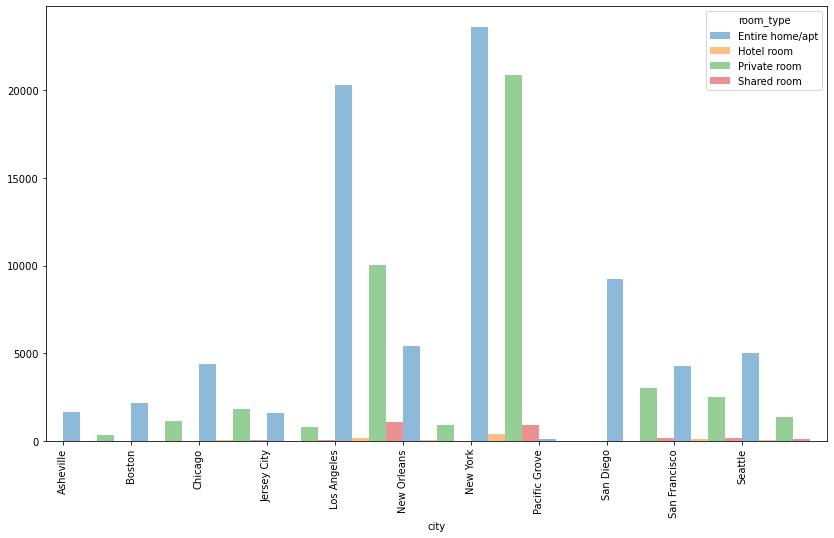

In [18]:
# roomtypes in different cities
room_type_df = merged_data.groupby(["city","room_type"]).size()
room_type_df = room_type_df.unstack()
room_type_df.plot(kind='bar', alpha=0.5, width=1.0, align="edge", figsize=(14,8))

Text(0.5, 1.0, 'Average Housing Price by Cities')

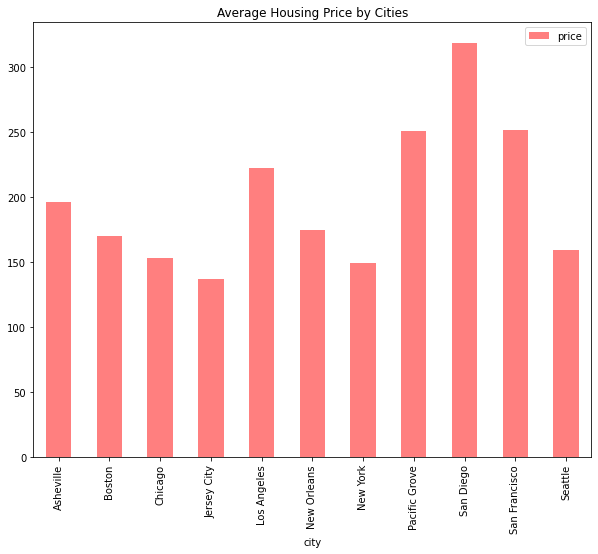

In [19]:
new_mean_df[['price']].plot(kind='bar',color='r', alpha=0.5, width=.5, align="center", figsize=(10,8))
plt.title('Average Housing Price by Cities')

Text(0.5, 1.0, 'Average AirBnB Price by Cities')

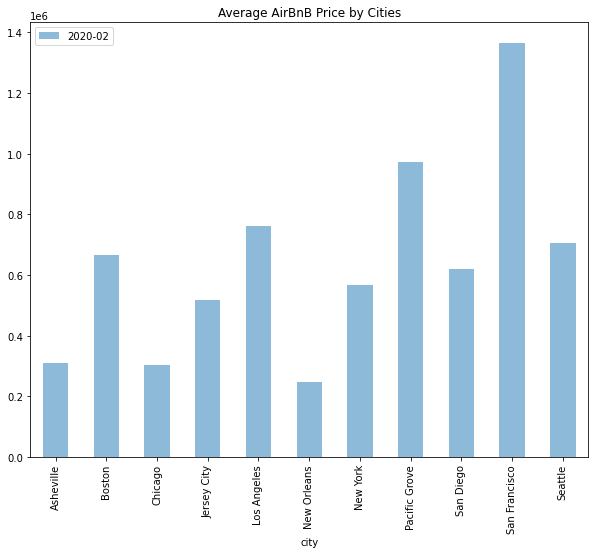

In [20]:
new_mean_df[['2020-02']].plot(kind='bar', alpha=0.5, width=0.5, align="center", figsize=(10,8))
plt.title('Average AirBnB Price by Cities')

In [21]:
x_values=new_mean_df['price'].tolist()
y_values=new_mean_df['2020-02'].tolist()

# correlation
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")


The correlation between both factors is 0.49
